In [1]:
import gym, gym_snake
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

from torch.distributions import Categorical, kl
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
env = gym.make('snake-v0')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [35]:
A = [[-1e2,0,0,1e1,0,0],[0,-1e2,0,0,0,1e1],[0,0,-1e2,0,1e1,0]]
class DQN(nn.Module):

    def __init__(self, h, outputs):
        super(DQN, self).__init__()
        self.pi1 = nn.Linear(h,256)
        #self.pi1.weight = nn.Parameter(torch.tensor(A,dtype = torch.float),requires_grad=True)
        #self.pi2 = nn.Linear(256,256)
        self.v1  = nn.Linear(h,256)
        self.pi = nn.Linear(256, outputs)
        self.value = nn.Linear(256,1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        pi = F.leaky_relu(self.pi1(x))
        #pi = F.leaky_relu(self.pi2(pi))
        v = F.leaky_relu(self.v1(x))

        
        return Categorical(F.softmax(self.pi(pi),dim=-1)), self.value(v) 

In [62]:
BATCH_SIZE = 128
GAMMA = 0.95
EPS_START = .9
EPS_END = .3
EPS_DECAY = 100
TARGET_UPDATE = 5

n_actions =  env.action_space.n

policy_net = DQN(10, n_actions).to(device)
target_net = DQN(10, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()


DQN(
  (pi1): Linear(in_features=10, out_features=256, bias=True)
  (v1): Linear(in_features=10, out_features=256, bias=True)
  (pi): Linear(in_features=256, out_features=3, bias=True)
  (value): Linear(in_features=256, out_features=1, bias=True)
)

In [67]:

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            pi, value = policy_net(state)
            return pi.sample().view(-1,1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        

def plot(frame_idx, rewards,loss):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s. loss: %s.' % (frame_idx, rewards[-1],loss))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False,breaks = True):
    state=env.reset()
    total_reward = 0
    i = 0
    for t in count():
        i+=1
        # Select and perform an action
        state = torch.tensor(state,dtype=torch.float)
        if vis ==True:
            clear_output(True)
            plt.matshow(env.world)
            #plt.savefig("snake_{}.pdf".format(t))
            plt.show()
        pi, value = policy_net(state)
        action    = pi.sample().view(-1,1)
        #print(pi,action,state)
        state, reward, done, _ = env.step(action.item())
        if reward>0:
            i=0
        #print(reward)
        total_reward+=reward
        #time.sleep(10)
        if done or (i>1e4 and breaks):
            break
    #print(total_reward)
    return total_reward

class HLoss(nn.Module):
    def __init__(self):
        super(HLoss, self).__init__()

    def forward(self, x):
        b = -(x+1e-9)*(x+1e-9).log()
        b = b.sum()
        return b

MU            = .7
LEARNING_RATE = 5e-4
update_lr = lambda x: x -2e-7 if steps_done%1001 != 0 else x + 2e-4
memory = ReplayMemory(1024)
optimizer = optim.RMSprop(policy_net.parameters(),lr=LEARNING_RATE)
d_target = .5
targ_beta = 1
def optimize_model():
    global d_target, targ_beta,alpha
    if len(memory) < BATCH_SIZE:
        return 0
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.stack([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_probs, state_values =  policy_net(state_batch)
    log_probs = state_probs.log_prob(action_batch)
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    _, next_values = policy_net(non_final_next_states)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    old_probs, old_values = target_net(state_batch)
    old_log = old_probs.log_prob(action_batch)
    next_state_values[non_final_mask] =next_values.view(-1).detach()
    # Compute the expected Q values
    kl_div = kl.kl_divergence(state_probs,old_probs).mean()
    d = kl_div.mean()
    if d>1.5*d_target:
        targ_beta*=2
    elif d<d_target/1.5:
        targ_beta/=2
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch.float()
    loss1 = (expected_state_action_values-state_values).pow(2)
    loss2 = (expected_state_action_values-(old_values.detach()+torch.clamp(state_values-old_values.detach(),-.1*alpha,.1*alpha))).pow(2)
    # Compute Huber loss
    r = torch.exp(log_probs-old_log.detach())
    A = expected_state_action_values-state_values
    loss_A = -torch.max(r*A.detach(),torch.clamp(r,1-.1*alpha,1+.1*alpha)*A.detach())
    loss_v = torch.max(loss1,loss2).pow(2)
    entropy = state_probs.entropy()

    loss = loss_A.mean()+loss_v.mean()-1e-2*entropy.mean()
    
    optimizer.zero_grad()
    loss.backward()
    #for param in policy_net.parameters():
        #param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss.item()
        
    

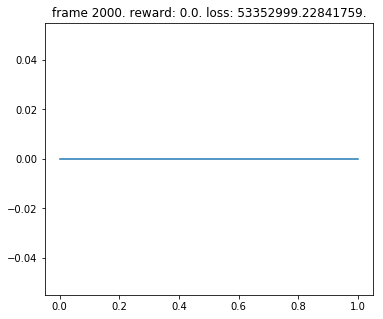

KeyboardInterrupt: 

In [68]:
env.alpha = .99
num_episodes = 1000
test_rewards = []
rolling_loss = 0
rolling_reward = 0
beta = .9
alpha = 1
for i_episode in range(num_episodes):
    alpha-=1/num_episodes
    # Initialize the environment and state
    #env.reset()
    state = torch.tensor(env.reset(),dtype=torch.float)
    #temp = []
    flag = False
    #print(i_episode)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        if not done:
            next_state = torch.tensor(next_state,dtype=torch.float)
        else:
            next_state = None
        
        # Store the transition in memory
       
        
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        if steps_done%1000==0 and len(memory) > 128:
            #transitions = memory.sample(128)
            #batch = Transition(*zip(*transitions))
            #reward_batch = torch.cat(batch.reward)
            #rolling_reward = (1-beta)*reward_batch.float().mean().item()+beta*rolling_reward
            test_rewards.append(np.mean([test_env() for _ in range(10)]))
            plot(steps_done, test_rewards,rolling_loss)
        # Perform one step of the optimization (on the target network)
        if i_episode>10:
            rolling_loss = (1-beta)*optimize_model()+beta*rolling_loss
        if done:
            episode_durations.append(t + 1)
            #plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

        
print('Complete')
env.close()
plt.ioff()
plt.show()


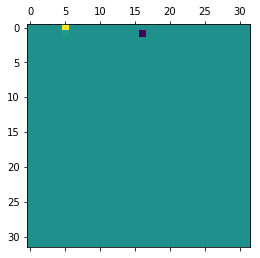

-100


In [61]:
import time
#import matplotlib.pyplot as plt
env.reset()
total_reward = 0
for t in count():
    # Select and perform an action
    state = torch.tensor(env.state,dtype=torch.float)
    #if vis ==True:
    clear_output(True)
    plt.matshow(env.world)
    #plt.savefig("snake_{}.pdf".format(t))
    plt.show()
    pi, value = policy_net(state)
    action    = pi.sample()
    #print(pi,action,state)
    _, reward, done, _ = env.step(action.item())
    #print(reward)
    total_reward+=reward
    #time.sleep(10)
    if done:
        break
print(total_reward)

In [75]:
transitions = memory.sample(BATCH_SIZE)
batch = Transition(*zip(*transitions))
state_batch = torch.stack(batch.state)


In [49]:
F.softmax(policy_net(state_batch[:,:-1].view(-1,1,32,32))/policy_net(state_batch[:,:-1].view(-1,1,32,32)).norm())

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.3328, 0.3371, 0.3301],
        [0.3291, 0.3396, 0.3313],
        [0.3323, 0.3350, 0.3327],
        [0.3317, 0.3361, 0.3323],
        [0.3335, 0.3370, 0.3295],
        [0.3325, 0.3360, 0.3315],
        [0.3326, 0.3356, 0.3318],
        [0.3330, 0.3369, 0.3301],
        [0.3330, 0.3351, 0.3319],
        [0.3366, 0.3398, 0.3236],
        [0.3318, 0.3359, 0.3323],
        [0.3337, 0.3362, 0.3302],
        [0.3322, 0.3350, 0.3328],
        [0.3322, 0.3359, 0.3319],
        [0.3332, 0.3365, 0.3303],
        [0.3307, 0.3365, 0.3328],
        [0.3324, 0.3357, 0.3319],
        [0.3269, 0.3409, 0.3322],
        [0.3306, 0.3424, 0.3270],
        [0.3331, 0.3375, 0.3294],
        [0.3325, 0.3349, 0.3326],
        [0.3320, 0.3408, 0.3272],
        [0.3314, 0.3361, 0.3325],
        [0.3314, 0.3361, 0.3325],
        [0.3328, 0.3354, 0.3318],
        [0.3311, 0.3369, 0.3320],
        [0.3308, 0.3373, 0.3319],
        [0.3322, 0.3348, 0.3330],
        [0.3277, 0.3410, 0.3314],
        [0.331

In [45]:
batch = Transition(*zip(*transitions))

# Compute a mask of non-final states and concatenate the batch elements
# (a final state would've been the one after which simulation ended)
non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                      batch.next_state)), device=device, dtype=torch.uint8)
non_final_next_states = torch.stack([s for s in batch.next_state
                                            if s is not None])
state_batch = torch.stack(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward)

In [204]:
state_action_values = policy_net.forward(state_batch[:,:-1].view(-1,1,32,32)).gather(1, action_batch)

In [33]:
next_state_values = torch.zeros(BATCH_SIZE, device=device)
next_state_values[non_final_mask] = target_net.forward(non_final_next_states[:,:-1].view(-1,1,32,32)).max(1)[0].detach()
# Compute the expected Q values
expected_state_action_values = (next_state_values * GAMMA) + reward_batch.float()

In [35]:
loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

In [36]:
loss

tensor(184.3784, grad_fn=<SmoothL1LossBackward>)

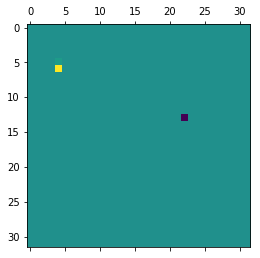

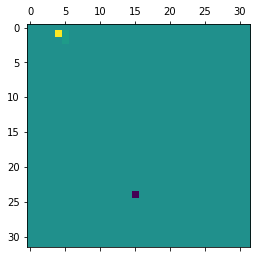

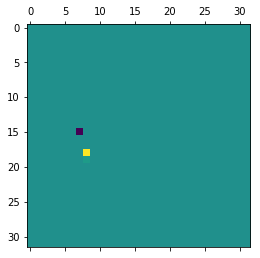

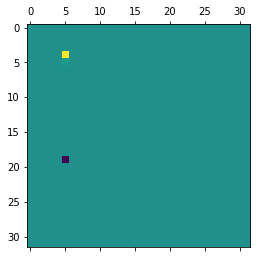

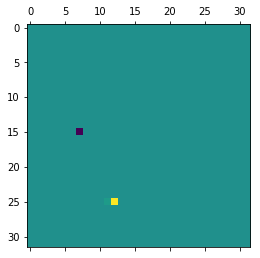

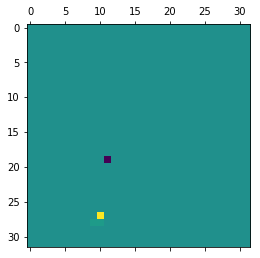

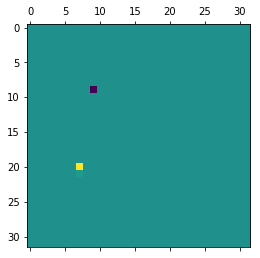

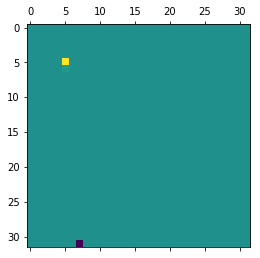

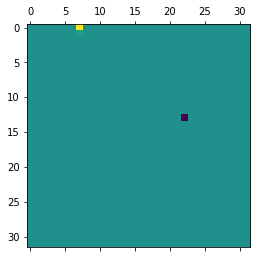

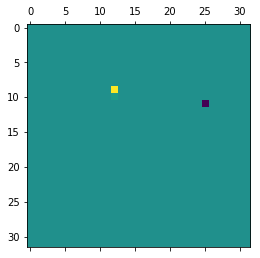

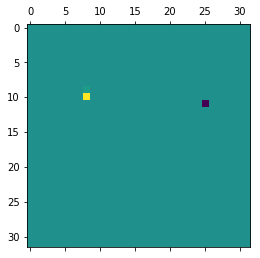

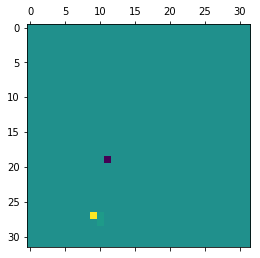

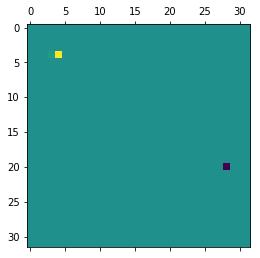

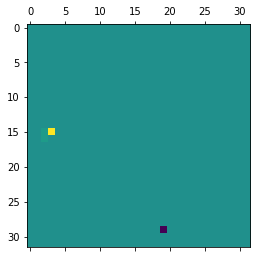

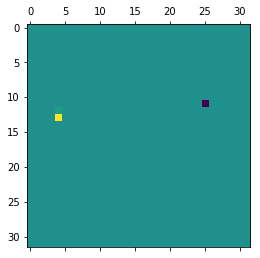

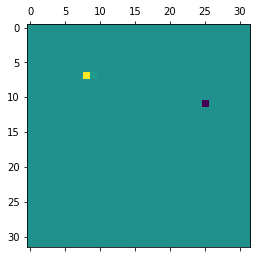

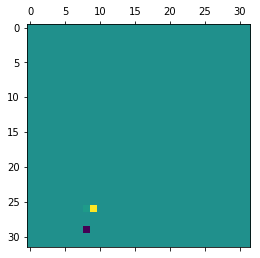

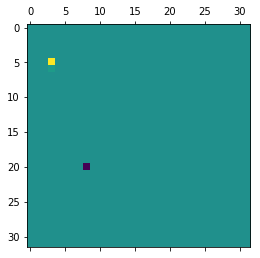

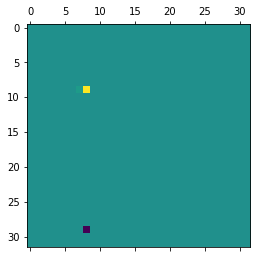

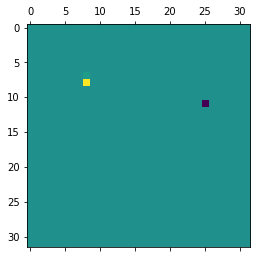

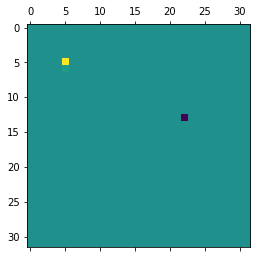

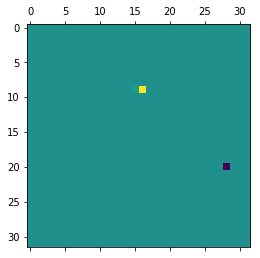

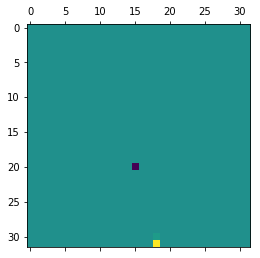

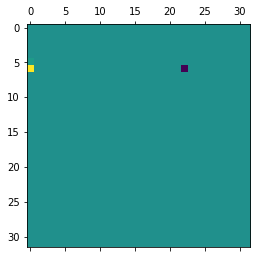

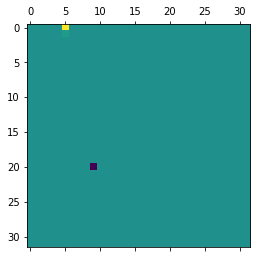

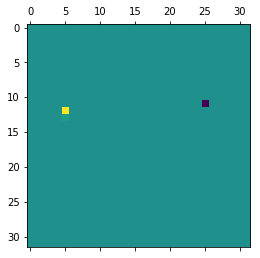

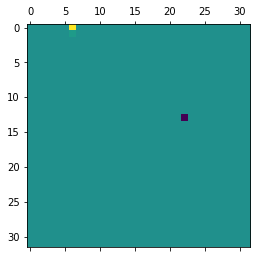

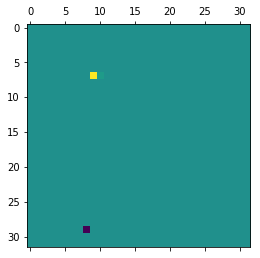

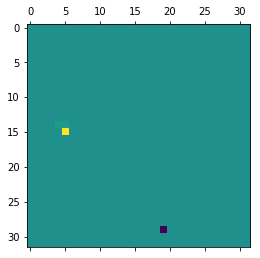

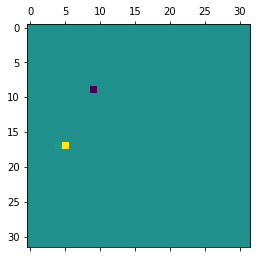

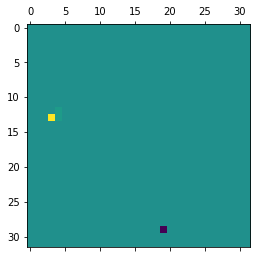

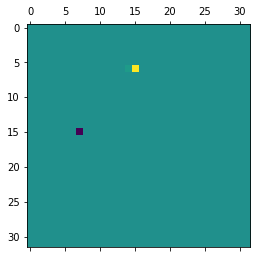

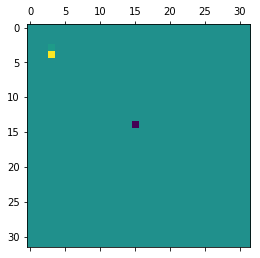

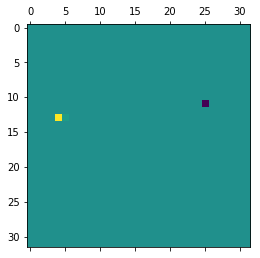

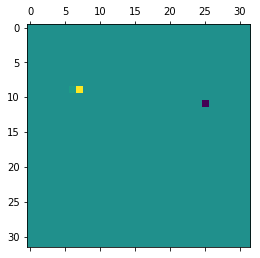

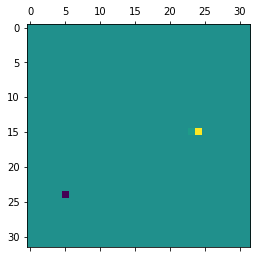

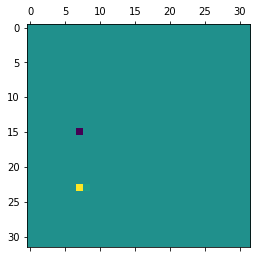

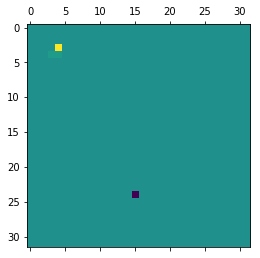

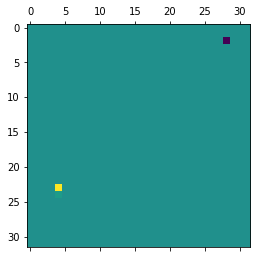

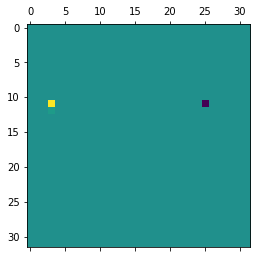

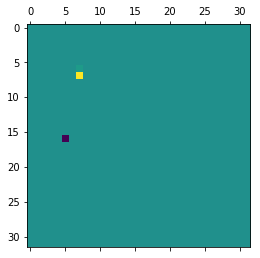

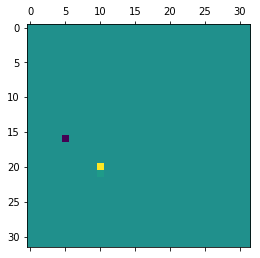

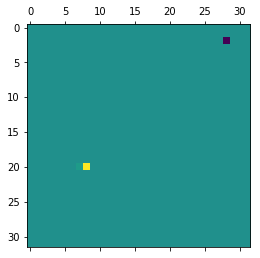

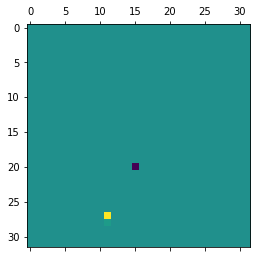

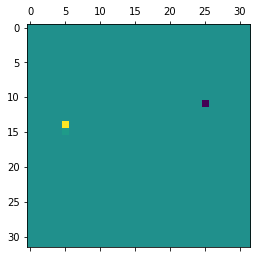

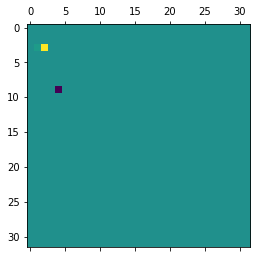

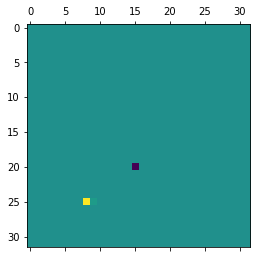

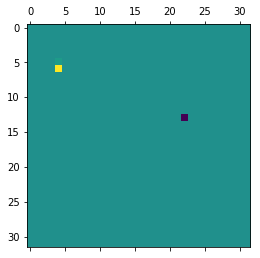

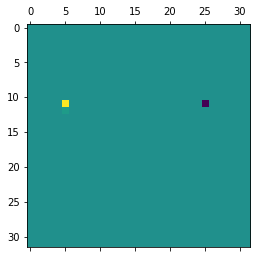

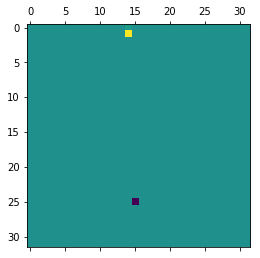

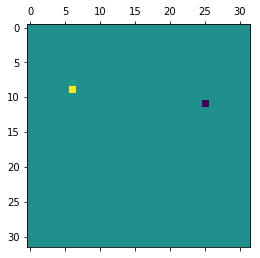

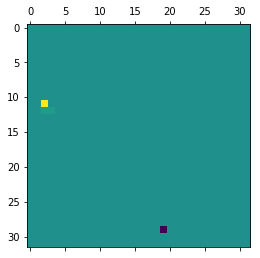

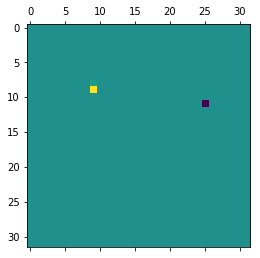

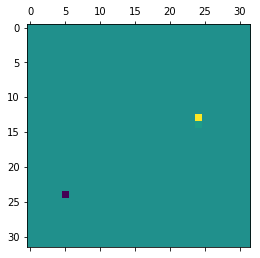

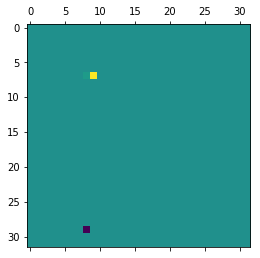

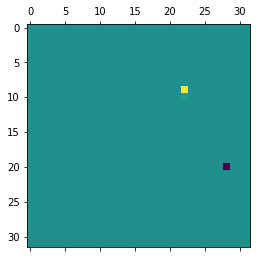

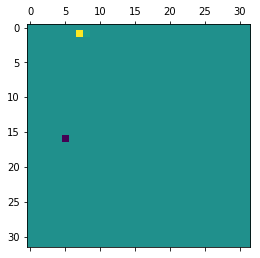

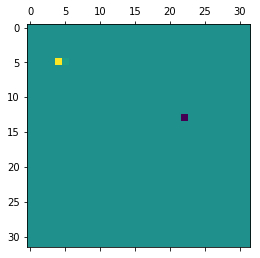

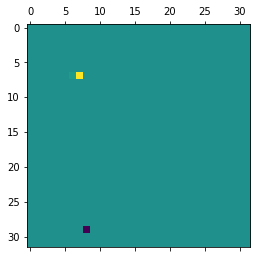

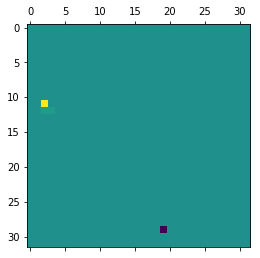

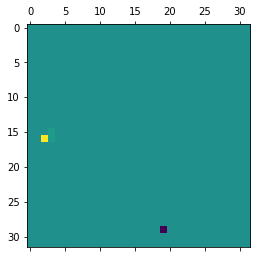

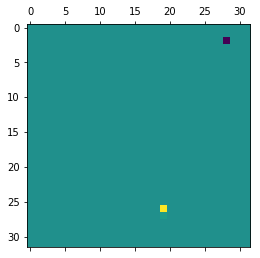

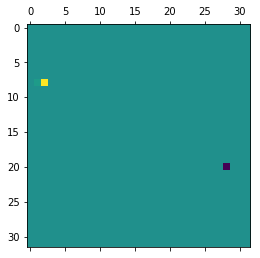

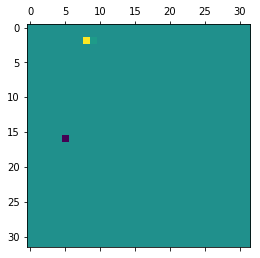

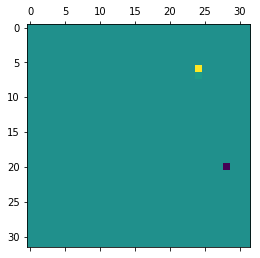

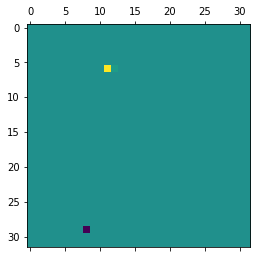

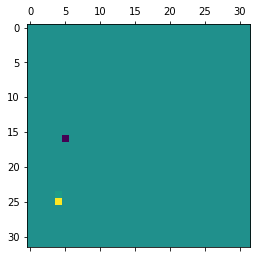

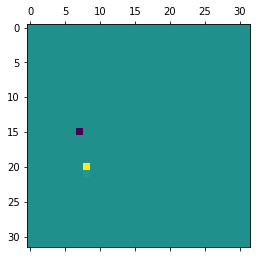

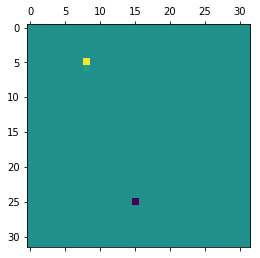

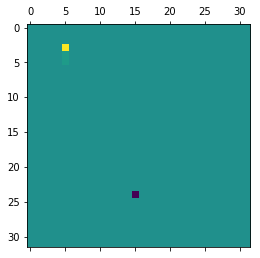

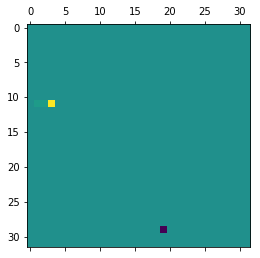

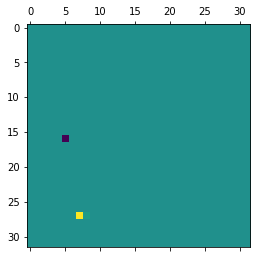

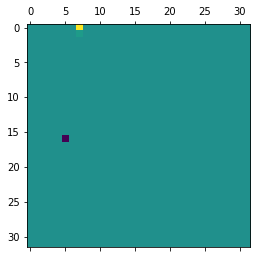

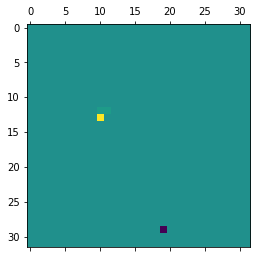

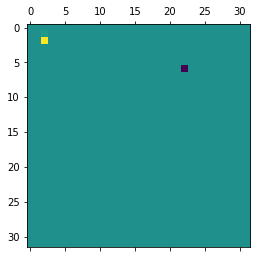

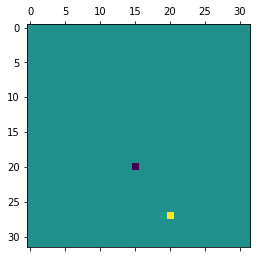

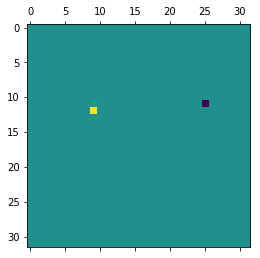

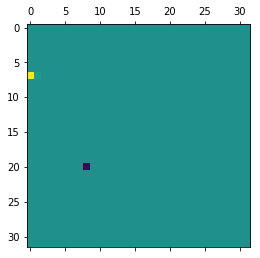

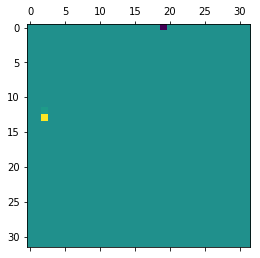

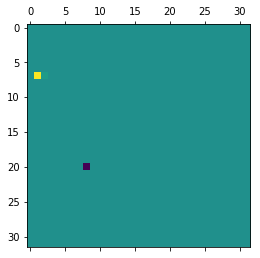

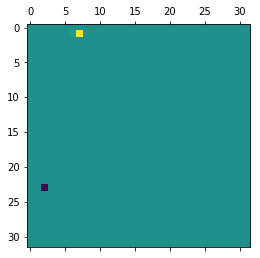

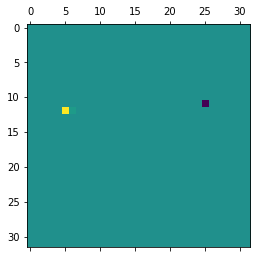

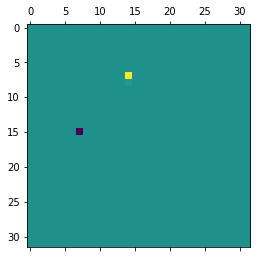

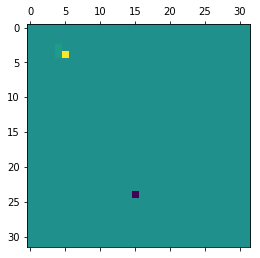

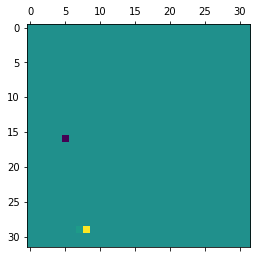

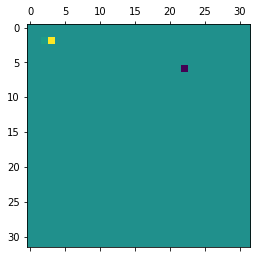

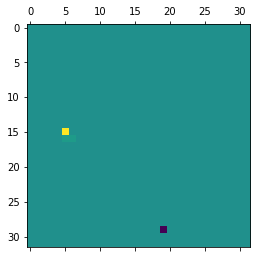

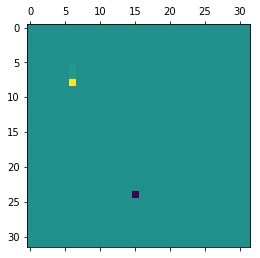

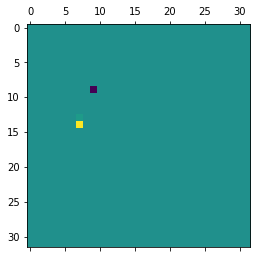

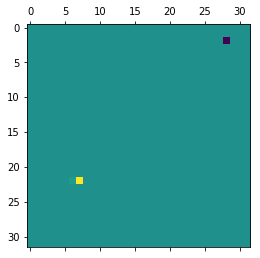

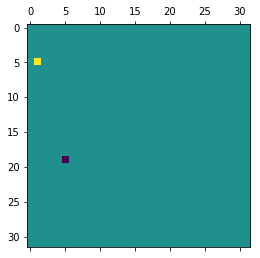

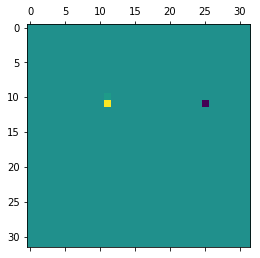

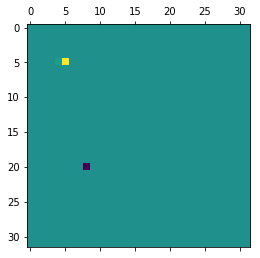

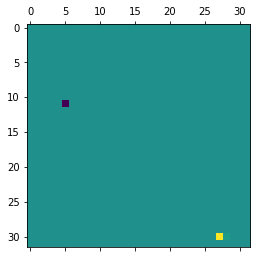

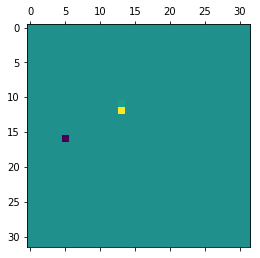

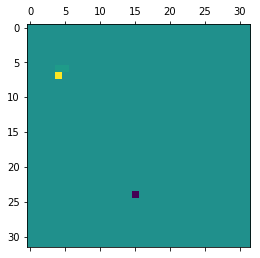

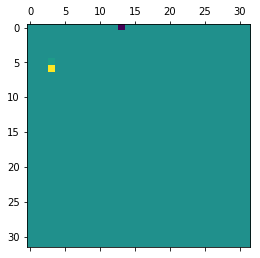

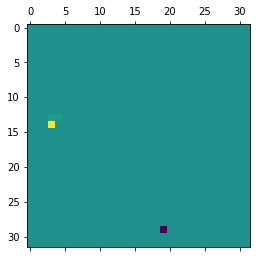

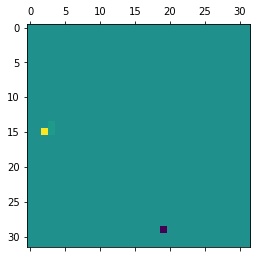

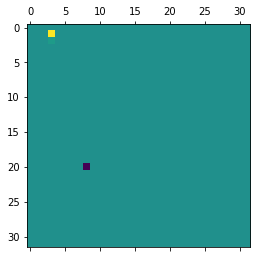

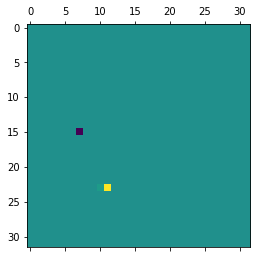

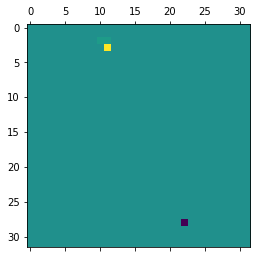

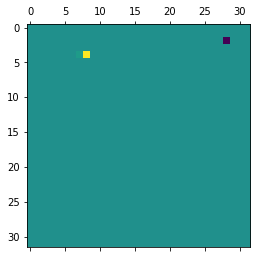

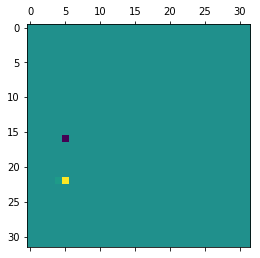

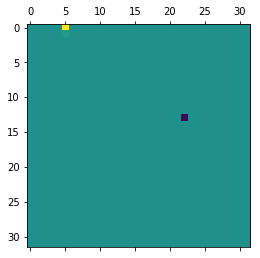

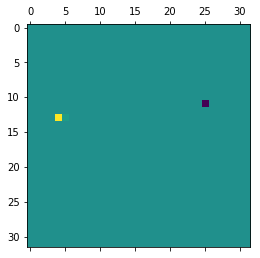

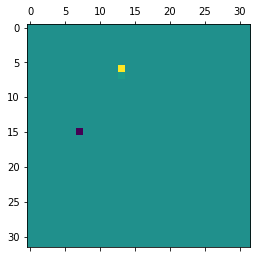

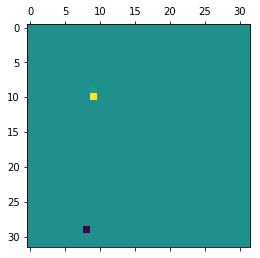

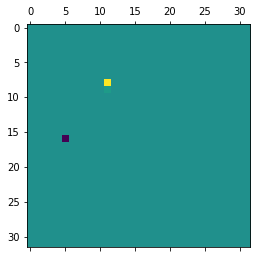

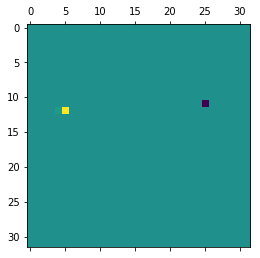

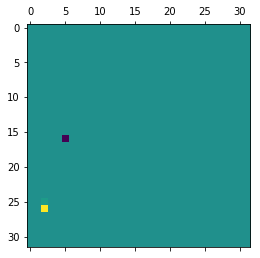

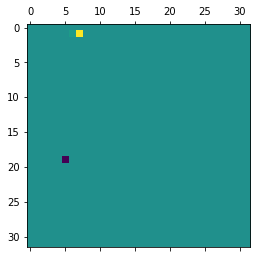

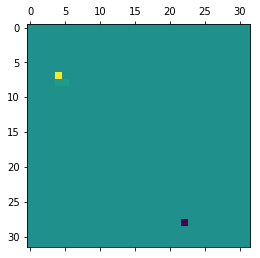

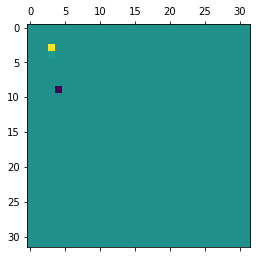

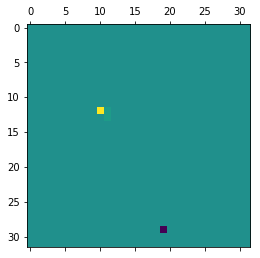

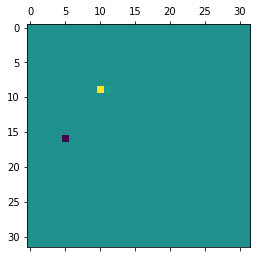

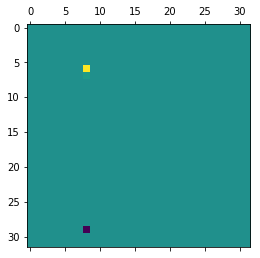

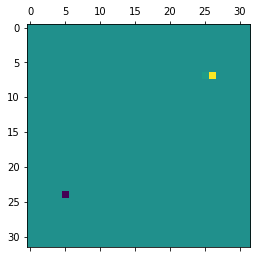

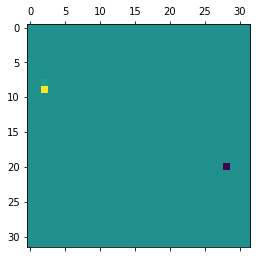

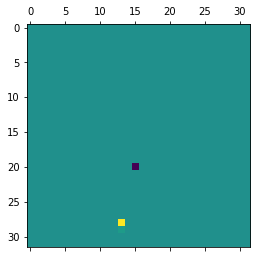

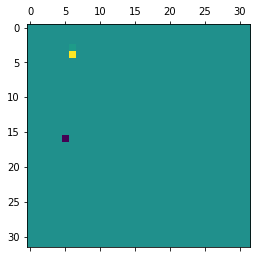

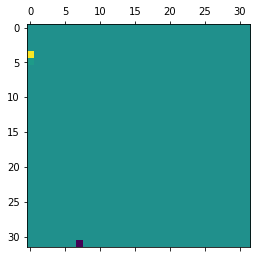

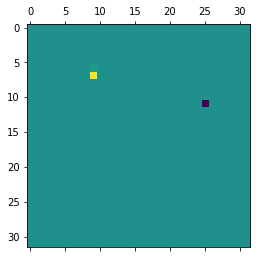

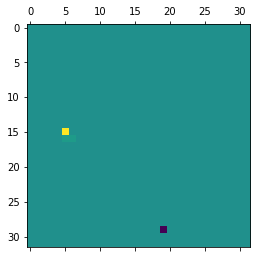

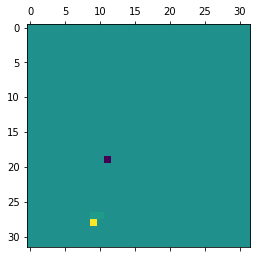

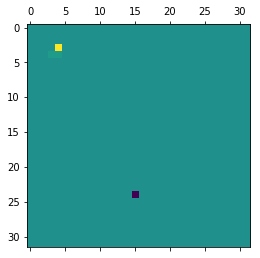

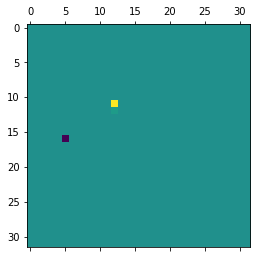

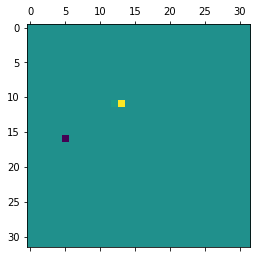

In [161]:
for state in state_batch:
    plt.matshow(state[:-1].reshape(32,32))
    plt.show()

In [169]:
memory.memory[memory.position%memory.capacity].action.item() == memory.memory[memory.position-1%memory.capacity].action.item()

False

In [189]:
(memory.memory[memory.position%memory.capacity].action.item()
 ==memory.memory[memory.position-1%memory.capacity].action.item()
 ==memory.memory[memory.position-2%memory.capacity].action.item()==
 memory.memory[memory.position-3%memory.capacity].action.item())

IndexError: list index out of range

In [173]:
memory.memory[memory.position-4%memory.capacity].action.item()

1

In [188]:
len(memory.memory)

9

In [215]:
reward_batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
policy_net.conv2(F.relu(policy_net.bn1(policy_net.conv1(state[:-1].view(-1,1,32,32)))))

torch.Size([1, 32, 24, 24])

In [32]:
state[:-1].view(-1,1,32,32)

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [41]:
12800/32

400.0

In [62]:
pi.gather(1,action_batch)

tensor([[0.4304],
        [0.3989],
        [0.3376],
        [0.3229],
        [0.3567],
        [0.3467],
        [0.3241],
        [0.3112],
        [0.2409],
        [0.3754],
        [0.3207],
        [0.3189],
        [0.3367],
        [0.4673],
        [0.3988],
        [0.3736],
        [0.3521],
        [0.3583],
        [0.3571],
        [0.4710],
        [0.3693],
        [0.3476],
        [0.3233],
        [0.3233],
        [0.3360],
        [0.4443],
        [0.3827],
        [0.3237],
        [0.3275],
        [0.3018],
        [0.3745],
        [0.2706],
        [0.3371],
        [0.3268],
        [0.3682],
        [0.3995],
        [0.3250],
        [0.3572],
        [0.4170],
        [0.3910],
        [0.3964],
        [0.3043],
        [0.4135],
        [0.3497],
        [0.3287],
        [0.3573],
        [0.3356],
        [0.3608],
        [0.2885],
        [0.4601],
        [0.3696],
        [0.3311],
        [0.4363],
        [0.3418],
        [0.3848],
        [0

In [97]:
pi, value =policy_net.forward(state[:-1].view(-1,1,32,32))

In [96]:
criterion = HLoss()

In [98]:
criterion(pi)

tensor(1.0860, grad_fn=<MulBackward0>)

In [169]:
transitions = memory.sample(BATCH_SIZE)
# Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
# detailed explanation). This converts batch-array of Transitions
# to Transition of batch-arrays.
batch = Transition(*zip(*transitions))
# Compute a mask of non-final states and concatenate the batch elements
# (a final state would've been the one after which simulation ended)
non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                      batch.next_state)), device=device, dtype=torch.uint8)
non_final_next_states = torch.stack([s for s in batch.next_state
                                            if s is not None])
state_batch = torch.stack(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward)

# columns of actions taken. These are the actions which would've been taken
# for each batch state according to policy_net
state_probs, state_values =  policy_net(state_batch[:,:-1].view(-1,1,32,32))

# Compute V(s_{t+1}) for all next states.
# Expected values of actions for non_final_next_states are computed based
# on the "older" target_net; selecting their best reward with max(1)[0].
# This is merged based on the mask, such that we'll have either the expected
# state value or 0 in case the state was final.
next_probs, next_values = target_net(non_final_next_states[:,:-1].view(-1,1,32,32))
next_state_values = torch.zeros(BATCH_SIZE, device=device)
old_probs, old_values = target_net(state_batch[:,:-1].view(-1,1,32,32))
next_state_values[non_final_mask] = next_values.view(-1).detach()
# Compute the expected Q values
expected_state_action_values = (next_state_values * GAMMA) + reward_batch.float()
critereon = HLoss()
# Compute Huber loss
r = state_probs.gather(1,action_batch)/old_probs.gather(1,action_batch)
A = expected_state_action_values-state_values
loss_A = torch.max(r*-A,torch.clamp(r,.8,1.2)*-A)
loss_v = A**2
entorpy = critereon(state_probs)

loss = loss_A.mean()+loss_v.mean()-1e-4*entorpy.mean()

In [109]:
loss.backward()

In [134]:
loss

tensor(nan, grad_fn=<SubBackward0>)

In [9]:
state_probs

NameError: name 'state_probs' is not defined

In [161]:
loss_v

tensor([[26.0543]], grad_fn=<PowBackward0>)

In [170]:
loss_A

tensor([[1.7334]], grad_fn=<MaxBackward2>)

In [163]:
-A

tensor([[-5.1043]], grad_fn=<SubBackward0>)

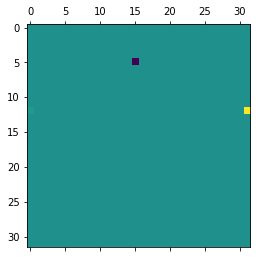

-1

In [41]:
test_env(True,False)

In [80]:
A = np.array([[1,2],[3,4]])

In [84]:
A.reshape(-1,4)

array([[1, 2, 3, 4]])

In [13]:
transitions = memory.sample(BATCH_SIZE)
# Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
# detailed explanation). This converts batch-array of Transitions
# to Transition of batch-arrays.
batch = Transition(*zip(*transitions))
# Compute a mask of non-final states and concatenate the batch elements
# (a final state would've been the one after which simulation ended)
non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                      batch.next_state)), device=device, dtype=torch.uint8)
non_final_next_states = torch.stack([s for s in batch.next_state
                                            if s is not None])
state_batch = torch.stack(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward)

RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 1 and 2 at /Users/administrator/nightlies/pytorch-1.0.0/wheel_build_dirs/conda_3.7/conda/conda-bld/pytorch_1544144746443/work/aten/src/TH/generic/THTensorMoreMath.cpp:1324

In [14]:
batch.action

(tensor([2]),
 tensor([2]),
 tensor([2]),
 tensor([[0]]),
 tensor([[0]]),
 tensor([[1]]),
 tensor([2]),
 tensor([[0]]),
 tensor([2]),
 tensor([2]),
 tensor([2]),
 tensor([[2]]),
 tensor([2]),
 tensor([2]),
 tensor([[0]]),
 tensor([2]))

In [16]:
env.reset()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.50000469e-01,
       1.00001000e+05])

In [25]:
soft_max = lambda x: np.exp(x)/np.sum(np.exp(x))

In [37]:
def optimal(state):
    a = 0 if state[0]==0 else -1e2
    b = 0 if state[1]==0 else -1e2
    c = 0 if state[2]==0 else -1e2
    if state[3]:
        a+=1e1
    if state[5]:
        b+=1e1
    if state[4]:
        c+=1e1
    #print(a,b,c)
    return soft_max(np.array([a,b,c]))
        

In [23]:
A = [[-1e2,0,0,1e1,0,0],[0,-1e2,0,0,0,1e1],[0,0,-1e2,0,1e1,0]]

0 10.0 0


array([4.53958078e-05, 9.99909208e-01, 4.53958078e-05])

In [21]:
soft_max(np.array([0,1000,0]))

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([ 0., nan,  0.])

In [35]:
def test_optim(vis=False):
    state = env.reset()
    if vis:
        clear_output(True)
        env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)

        dist, _ = policy_net(state)
        action = torch.multinomial(torch.tensor(optimal(env.state),dtype=torch.float),1)
        next_state, reward, done, _ = env.step(action.item())
        state = next_state
        if vis:
            clear_output(True)
            env.render()
        total_reward += reward
        if total_reward<-1e5:
            break
    return total_reward


In [39]:
np.mean([test_optim() for _ in range(100)])

5242.7

In [69]:
policy_net(torch.tensor(env.state,dtype = torch.float))

(tensor([5.0974e-01, 3.8650e-05, 4.9022e-01], grad_fn=<SoftmaxBackward>),
 tensor([71.2727], grad_fn=<AddBackward0>))

In [70]:
optimal(env.state)

array([4.99988650e-01, 2.26994496e-05, 4.99988650e-01])

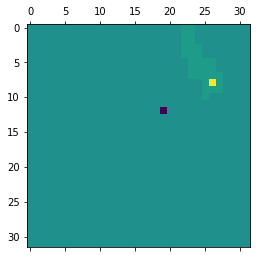

7540

In [82]:
test_env(vis=True)

In [9]:
env.state()

AttributeError: 'TimeLimit' object has no attribute 'state'